## This notebook will create an interactive widget to illustrate network interconnections

In [25]:
import numpy as np
from pandas import *
import networkx as nx
import matplotlib.pyplot as plt
        
% matplotlib inline

### Import real gene network (from macular degeneration experiment)

Also import the measured differential expression levels

NOTE: change paths/filenames in this cell to apply network visualizer to other datasets.  Network format from genemania (e.g. columns are 'Entity 1', 'Entity 2', 'Weight', 'Network_group', 'Networks')

NOTE: if no fold change analysis desired, set diff_exp_analysis=False

In [26]:
# set file name and directory: network format from GeneMania


filename = 'ayyagari_mass_spec_MD_network/09232015_ayyagari_mass_spec_genemania_network.txt'  

md_network = read_csv(filename, sep='\t', header=6)
md_network.columns = ['Entity 1','Entity 2', 'Weight','Network_group','Networks']

print(md_network.head())

# also import differential expression
diff_exp_analysis = True
if diff_exp_analysis:
    md_diff_exp = read_csv('ayyagari_mass_spec_MD_network/09232015_ayyagari_mass_spec_fold_changes.csv',sep=',')
    md_diff_exp.index = md_diff_exp['GeneSymbol']
    
    # drop empty columns
    md_diff_exp = md_diff_exp.dropna(axis='columns',how='all')

    md_diff_exp.columns = ['GeneSymbol','FoldChange']  # rename columns to be more universal
    print('\n \n Differential expression (fold change): \n')
    print(md_diff_exp.FoldChange[1:20])
    




  Entity 1 Entity 2    Weight  Network_group  \
0     C1qc     C1qb  0.226386  Co-expression   
1     C1qa     C1qc  0.214313  Co-expression   
2     C1qa     C1qb  0.205126  Co-expression   
3   Atp2a1     Myl1  0.169756  Co-expression   
4   Atp2a1     Myh1  0.164160  Co-expression   

                                            Networks  
0  [Andrechek-Nevins-2009, Boivin-Vidal-2012, Gal...  
1  [Akerblad-Sigvardsson-2005, Anderson-Neville-2...  
2  [Andrechek-Nevins-2009, Boivin-Vidal-2012, Gal...  
3  [Anderson-Neville-2007, Andrechek-Nevins-2009,...  
4  [Anderson-Neville-2007, Andrechek-Nevins-2009,...  

 
 Differential expression (fold change): 

GeneSymbol
Apoa1           -2
Aspn           2.2
Atl3            -3
Atp2a1         3.6
Bsg              4
C1qtnf5         13
Cald1          4.5
Capn2         -6.7
Cfh           -2.5
Cfhr1           -2
Copa          -2.5
Copg2            8
Cryaa           -4
Ctsb          -1.7
Cyfip1          -2
Cyfip2          -3
Dnm2            -4
Dp

### Section: Implement heat diffusion (HotNet2)

Note- these functions moved to plot_network module

### Create sample network

Create a random network using networkx, for use in testing widget

In [27]:
G_rand = nx.connected_watts_strogatz_graph(200,4,.1)
#G_rand = nx.random_graphs.powerlaw_cluster_graph(100,10,.2)
edges = G_rand.edges()
numedges = len(G_rand.edges())
for e in range(numedges):
    edge_temp = edges[e]+(np.random.rand(),)
    edges[e] = edge_temp

nodes = G_rand.nodes()
G_rand.add_weighted_edges_from(edges)


# rename nodes to strings for compatibility with widget
string_nodes = [str(i) for i in nodes]
node_map = dict(zip(nodes,string_nodes))
G_rand = nx.relabel_nodes(G_rand,node_map,copy=False)



In [28]:
# use md_network to build adjacency matrix
G_MD = nx.Graph()
G_MD.add_nodes_from(list(md_network['Entity 1']))
print(G_MD.nodes())
print('number of nodes = '+ str(len(G_MD.nodes())))

['Mtch1', 'Maoa', 'Hrg', 'Itgb2', 'Anxa6', 'C1qtnf2', 'C1qtnf3', 'Lsp1', 'C1qtnf1', 'C1qtnf6', 'C1qtnf7', 'C1qtnf4', 'Tcirg1', 'Otol1', 'Steap3', 'Ehd4', 'Sec23a', 'Ehd1', 'Cfh', 'Thbs1', 'Picalm', 'Col8a2', 'Col8a1', 'Serpina3m', 'Serpina3n', 'Tubb6', 'Dpep1', 'Dpep2', 'C1ql1', 'C1ql2', 'C1ql3', 'C1ql4', 'Idh2', 'Aspn', 'Dync1h1', 'Itgax', 'Thy1', 'Fgg', 'Fga', 'Fgb', 'Dpep3', 'Tap2', 'Emilin1', 'C1qtnf9', 'Myl1', 'Tkt', 'Myoc', 'Cald1', 'Ctsb', 'Cryaa', 'Gpc1', 'Copg2', 'Serpina1e', 'Hhatl', 'Atp2a1', 'Dtna', 'Parva', 'Uqcrc1', 'Eif3e', 'C1qbp', 'Postn', 'Tnc', 'Tubb4b', 'Serpinb6a', 'Hpx', 'Cyfip1', 'Cyfip2', 'Vcl', 'Capn2', 'Ppia', 'Copa', 'C1qc', 'C1qb', 'C1qa', 'Ndufs1', 'Lims1', 'Bsg', 'Adipoq', 'Cbln4', 'Cbln2', 'Cbln3', 'Dnm2', 'Myh1', 'Myh7', 'Myh4', 'Hmgb2', 'Apoa1']
number of nodes = 87


In [29]:
# add some edges
edge_list = zip(list(md_network['Entity 1']),list(md_network['Entity 2']))
G_MD.add_edges_from(edge_list)

print('number of edges = ' + str(len(G_MD.edges())))


number of edges = 933


In [30]:
# create version with weighted edges
G_MD_w = nx.Graph()
G_MD_w.add_nodes_from(G_MD.nodes())
edge_list_w = zip(list(md_network['Entity 1']),list(md_network['Entity 2']),list(md_network['Weight']))
    
G_MD_w.add_weighted_edges_from(edge_list_w)

In [31]:
import imp
import plot_network
imp.reload(plot_network)

<module 'plot_network' from 'plot_network.py'>

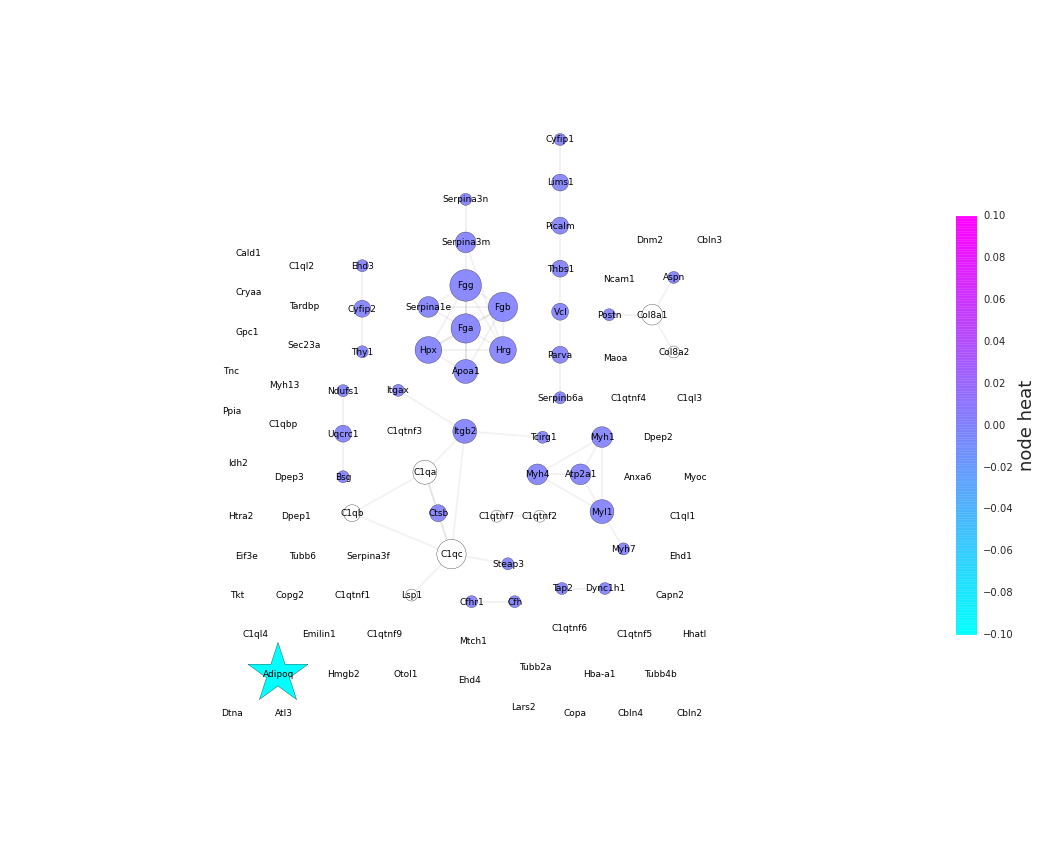

In [32]:
from IPython.html.widgets import interact
from IPython.html import widgets
import matplotlib.colorbar as cb
import seaborn as sns
import community

# import network plotting module
from plot_network import *

Gtest = nx.Graph()

# select whether you want to analyze real data or simulated network
net_type = 'data'

if net_type == 'data':
    Gtest.add_nodes_from(G_MD_w.nodes())
    Gtest.add_edges_from(G_MD_w.edges(data=True))
    
    # prep border colors
    nodes = Gtest.nodes()
    gene_list = md_diff_exp['GeneSymbol'].unique()
    
    if diff_exp_analysis:
        diff_exp = Series(md_diff_exp.FoldChange)
        genes_intersect = np.intersect1d(gene_list,nodes)
        border_cols = Series(index=nodes)

        for i in genes_intersect:
            if diff_exp[i]=='Unmeasured':
                border_cols[i] = np.nan
            else:
                border_cols[i] = diff_exp[i] 
    else:  # if no differential expression data
        border_cols = [None]

elif net_type == 'random':
    Gtest.add_nodes_from(G_rand.nodes())
    Gtest.add_edges_from(G_rand.edges(data=True))
    
    nodes = Gtest.nodes()
    
    # make border colors array of ones
    border_cols = np.ones(len(nodes))
    border_cols = Series(border_cols,index=nodes)
    
    # make other interaction type
    node_0_list = [u for (u,v) in Gtest.edges()]
    node_1_list = [v for (u,v) in Gtest.edges()]
    
    NGlist = ['Other' for i in range(len(Gtest.edges()))]
                   
    md_network = DataFrame({'Entity 1':node_0_list,'Entity 2': node_1_list,'Weight':np.ones(len(Gtest.edges())),
                           'Network_group':NGlist})


numnodes = len(Gtest)

# make these three global to feed into widget
global Gtest

global boder_cols  

global md_network

def plot_network_shell(focal_node_name,edge_thresh=.5,network_algo='spl',map_degree=True, plot_border_col=False, draw_shortest_paths=True,
                coexpression=True, colocalization=True, other=False,physical_interactions=False,
                 predicted_interactions=False,shared_protein_domain=False):
    
    # this is the main plotting function, called from plot_network module
    fig = plot_network(Gtest, border_cols, md_network,
                 focal_node_name, edge_thresh, network_algo, map_degree, plot_border_col, draw_shortest_paths,
                 coexpression, colocalization, other, physical_interactions, predicted_interactions, shared_protein_domain)


    return fig

# threshold slider parameters
if net_type=='data':
    min_thresh = np.min(md_network['Weight'])
    max_thresh = np.max(md_network['Weight']/50)
else:
    min_thresh = 0
    max_thresh = 1
    
thresh_step = (max_thresh-min_thresh)/1000.0

interact(plot_network_shell, focal_node_name=list(np.sort(nodes)),
         edge_thresh=widgets.FloatSliderWidget(min=min_thresh,max=max_thresh,step=thresh_step,value=min_thresh,description='edge threshold'),
         network_algo = ['community','clustering_coefficient','hotnet2','pagerank','spl']);


### To do: implement effective distance 

(From Brockmann, Helbing: The Hidden Geometry of Complex, Network-Driven Contagion Phenomena)

Calculate the effective distance as:

- Pij is the fraction of connections going from J to I
- Pij = Aij/sum_j(Aij)
- dij = 1/(1-log(Pij)
- D = all shortest paths in dij


### Also to do: 

- Implement alternative module/clustering mechanisms
- Implement force-directed edge bundling 
- add animation componenent (e.g. heat spreading from a source)


- how do network measures change with node removal?  Can we identify 'bottleneck' regions?  What is the best node/ edge to remove?

- calculate network backbone (http://www.pnas.org/content/106/16/6483.abstract)

In [33]:
HEBim = plt.imread('hierarchical_edge-bundling3.png')
#plt.figure(figsize=(12,12))
#plt.imshow(HEBim);